In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load the Iris dataset
iris_data = pd.read_csv('W04-IrisData.csv')

In [3]:
# Filter out Versicolor and Virginica samples
filtered_data = iris_data[iris_data['Species'].isin(['Iris-versicolor', 'Iris-virginica'])]

In [4]:
# Select the required features and label
filtered_data = filtered_data[['PetalLengthCm', 'SepalWidthCm', 'Species']]

In [5]:
# Set ground truth labels
filtered_data['Species'] = filtered_data['Species'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)

In [6]:
# Separate Versicolor and Virginica
versicolor = filtered_data[filtered_data['Species'] == 0]
virginica = filtered_data[filtered_data['Species'] == 1]

In [7]:
# Split into training and test sets using train_test_split
versicolor_train, versicolor_test = train_test_split(versicolor, test_size=0.2, random_state=1)
virginica_train, virginica_test = train_test_split(virginica, test_size=0.2, random_state=1)

In [8]:
# Combine training and test sets
train_data = pd.concat([versicolor_train, virginica_train])
test_data = pd.concat([versicolor_test, virginica_test])

In [9]:
# Separate features and labels
X_train = train_data[['PetalLengthCm', 'SepalWidthCm']].values
y_train = train_data['Species'].values
X_test = test_data[['PetalLengthCm', 'SepalWidthCm']].values
y_test = test_data['Species'].values

In [10]:
# Zero-mean normalize the training set
mean_X_train = X_train.mean(axis=0)
std_X_train = X_train.std(axis=0)
X_train_normalized = (X_train - mean_X_train) / std_X_train

In [11]:
# Zero-mean normalize the test set using training set parameters
X_test_normalized = (X_test - mean_X_train) / std_X_train

In [12]:
# Display normalized training data
train_df_normalized = pd.DataFrame(X_train_normalized, columns=['PetalLengthCm', 'SepalWidthCm'])
print("Normalized Training Data:")
print(train_df_normalized.head())

Normalized Training Data:
   PetalLengthCm  SepalWidthCm
0      -1.276636     -0.491853
1      -1.151782     -1.111510
2      -1.151782     -0.182024
3      -0.277801      0.747461
4      -1.276636     -1.111510


In [13]:
# Display normalized test data
test_df_normalized = pd.DataFrame(X_test_normalized, columns=['PetalLengthCm', 'SepalWidthCm'])
print("Normalized Test Data:")
print(test_df_normalized.head())

Normalized Test Data:
   PetalLengthCm  SepalWidthCm
0       0.096762      0.437633
1      -0.527510      1.676947
2      -0.652364     -0.801681
3      -1.026927      0.437633
4      -0.028092      0.747461


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

In [15]:
# Define the neural network class
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Input layer to hidden layer 1
        self.fc2 = nn.Linear(5, 3)  # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(3, 1)  # Hidden layer 2 to output layer
        self.relu = nn.ReLU()       # ReLU activation function
        self.sigmoid = nn.Sigmoid() # Sigmoid activation function for output layer
    
    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply ReLU after first linear layer
        x = self.relu(self.fc2(x))  # Apply ReLU after second linear layer
        x = self.sigmoid(self.fc3(x)) # Apply Sigmoid after third linear layer
        return x

In [16]:
# Instantiate the model
model = IrisNet()

In [17]:
# Print model structure
print(model)

IrisNet(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [18]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [19]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [20]:
# Training function
def train_model(model, criterion, optimizer, X_train, y_train, X_test, y_test, num_epochs=5):
    train_acc_list = []
    test_acc_list = []
    
    for epoch in range(num_epochs):
        model.train()
        
        # Forward pass
        outputs = model(X_train)
        outputs = outputs.squeeze()
        loss = criterion(outputs, y_train.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train).squeeze()
            train_preds = (train_outputs >= 0.5).long()
            train_acc = (train_preds == y_train).sum().item() / y_train.size(0)
            
            test_outputs = model(X_test).squeeze()
            test_preds = (test_outputs >= 0.5).long()
            test_acc = (test_preds == y_test).sum().item() / y_test.size(0)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')
    
    return train_acc_list, test_acc_list


In [21]:
# Hyperparameters
num_epochs = 5
learning_rates = [0.001, 0.01, 0.1]
momentum = 0.9

In [22]:
# Store results
results = []

for lr in learning_rates:
    model = IrisNet()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    print(f'\nTraining with learning rate: {lr}')
    train_acc_list, test_acc_list = train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs)
    
    results.append({
        'learning_rate': lr,
        'train_accuracy': train_acc_list,
        'test_accuracy': test_acc_list
    })


Training with learning rate: 0.001
Epoch [1/5], Loss: 0.7060, Train Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch [2/5], Loss: 0.7060, Train Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch [3/5], Loss: 0.7059, Train Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch [4/5], Loss: 0.7059, Train Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch [5/5], Loss: 0.7057, Train Accuracy: 0.5000, Test Accuracy: 0.5000

Training with learning rate: 0.01
Epoch [1/5], Loss: 0.7308, Train Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch [2/5], Loss: 0.7296, Train Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch [3/5], Loss: 0.7275, Train Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch [4/5], Loss: 0.7247, Train Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch [5/5], Loss: 0.7216, Train Accuracy: 0.5000, Test Accuracy: 0.4500

Training with learning rate: 0.1
Epoch [1/5], Loss: 0.6921, Train Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch [2/5], Loss: 0.6825, Train Accuracy: 0.5250, Test Accuracy: 0.5000
Epoch [3/5], Loss: 

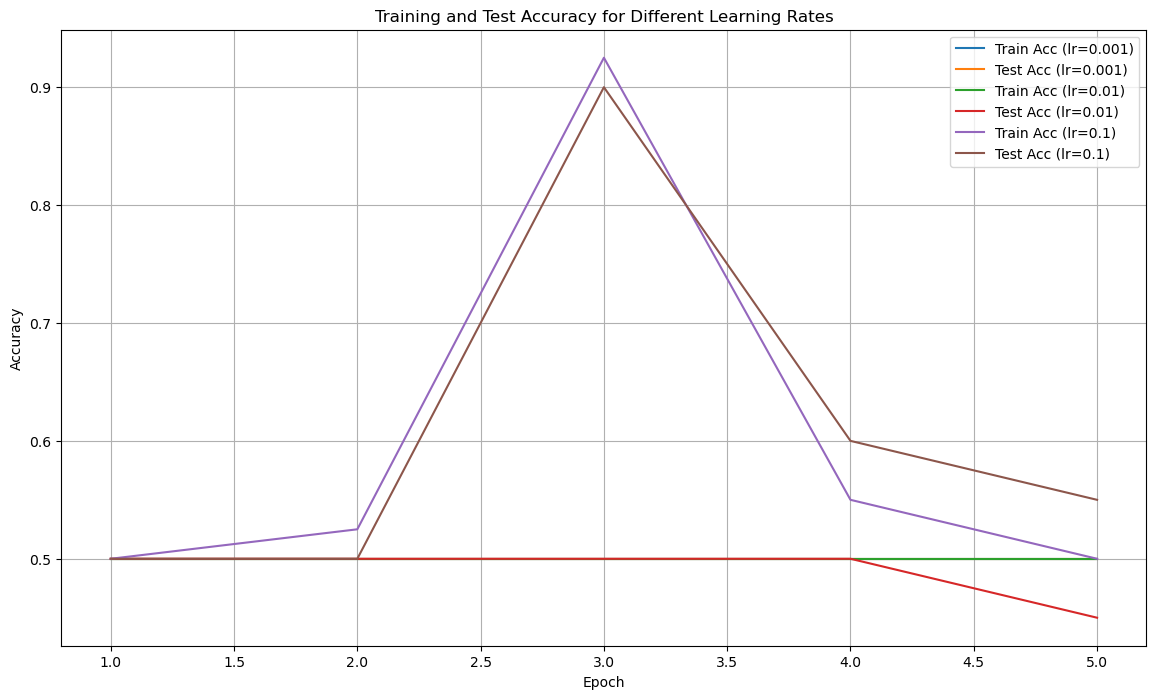

In [23]:
# Plotting the results
plt.figure(figsize=(14, 8))

for result in results:
    plt.plot(range(1, num_epochs+1), result['train_accuracy'], label=f'Train Acc (lr={result["learning_rate"]})')
    plt.plot(range(1, num_epochs+1), result['test_accuracy'], label=f'Test Acc (lr={result["learning_rate"]})')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Display results in a table
results_table = []

for result in results:
    for epoch in range(num_epochs):
        results_table.append({
            'Learning Rate': result['learning_rate'],
            'Epoch': epoch + 1,
            'Train Accuracy': result['train_accuracy'][epoch],
            'Test Accuracy': result['test_accuracy'][epoch]
        })

results_df = pd.DataFrame(results_table)
print(results_df)

    Learning Rate  Epoch  Train Accuracy  Test Accuracy
0           0.001      1           0.500           0.50
1           0.001      2           0.500           0.50
2           0.001      3           0.500           0.50
3           0.001      4           0.500           0.50
4           0.001      5           0.500           0.50
5           0.010      1           0.500           0.50
6           0.010      2           0.500           0.50
7           0.010      3           0.500           0.50
8           0.010      4           0.500           0.50
9           0.010      5           0.500           0.45
10          0.100      1           0.500           0.50
11          0.100      2           0.525           0.50
12          0.100      3           0.925           0.90
13          0.100      4           0.550           0.60
14          0.100      5           0.500           0.55
